In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import logm, expm
from scipy.stats import norm
from scipy.optimize import fsolve
from matplotlib import pyplot as plt

## Markov Chain
Let's consider a Markov Chain comprising three states: $G$, $B$, and $D$ (representing "good," "bad," and "default" respectively). The following is the risk-neutral probability transition matrix $M$ for a time period of 0.25 years.

\begin{equation*}
M(T=0.25) =
\begin{pmatrix}
99\% & 0.75\% & 0.25\% \\
1.75\% & 94.75\% & 3.5\% \\
0 & 0 & 1
\end{pmatrix}
\end{equation*}


The exponential form $e^{AT}$ provides a convenient way to express the transition matrix $M$, particularly when dealing with non-multiple time periods such as $M(T=0.3)$.

\begin{equation*}
e^{AT} = M(T)
\end{equation*}

In [2]:
# Parameters
T, M = 0.25, np.array([[0.99, 0.0075, 0.0025],
                       [0.0175, 0.9475, 0.035],
                       [0, 0, 1]])
A = logm(M)/T
print(f'Verify that the sum of each row equals one: {M.sum(axis=1)}')

Verify that the sum of each row equals one: [1. 1. 1.]


In [3]:
# Verify A
print(M @ M)
print(expm(A*0.5))

[[0.98023125 0.01453125 0.0052375 ]
 [0.03390625 0.8978875  0.06820625]
 [0.         0.         1.        ]]
[[0.98023125 0.01453125 0.0052375 ]
 [0.03390625 0.8978875  0.06820625]
 [0.         0.         1.        ]]


Let's consider a 6-year risky coupon bond that offers an annual coupon rate of 5% until it reaches maturity. The credit quality of the underlying firm can be characterized using the transition matrix $M$. In the event of a default by the underlying firm, the bond will become void, resulting in no recovery at the time of default.The risk-free (continuously compounded) interest rate is constant at 2%.

In [4]:
r = 0.02
Ts = [1, 2, 3, 4, 5, 6]
CFs = [5, 5, 5, 5, 5, 105]

price = np.array([0.0]*len(A))
for t, cf in zip(Ts, CFs):
  price += cf * np.exp(-r*t) * ( 1 - expm(A*t)[:, -1] )

print(f'when intial state is G, the bond price is {price[0]}')
print(f'when intial state is B, the bond price is {price[1]}')
print(f'when intial state is D, the bond price is {price[2]}')

when intial state is G, the bond price is 106.2244054724025
when intial state is B, the bond price is 63.2864736049127
when intial state is D, the bond price is 0.0


Encapsulate the bond pricing model within a class structure

In [5]:
class Markov_Chain:

    def __init__(self, M, T):
      self.A = logm(M) / T

    def transition_matrix(self, T):
      return expm(self.A * T)

    def bond_pricing(self, r, Ts, CFs):
      price = np.array([0.0]*len(self.A))
      for t, cf in zip(Ts, CFs):
        price += cf * np.exp(-r*t) * ( 1 - expm(A*t)[:, -1] )
      return price

In [6]:
# Verify the answer
markov_chain0 = Markov_Chain(M, T)
print(f'transition matrix M(T = 0.5) is: \n{markov_chain0.transition_matrix(0.5)}\n')
print(f'bond prices are: \n{markov_chain0.bond_pricing(r, Ts, CFs)}')

transition matrix M(T = 0.5) is: 
[[0.98023125 0.01453125 0.0052375 ]
 [0.03390625 0.8978875  0.06820625]
 [0.         0.         1.        ]]

bond prices are: 
[106.22440547  63.2864736    0.        ]


Let us consider $X(0,T)$ be the survival probability as a function of the horizon $T$. Define the term hazard rate $\lambda(T)$ as $X(0,T) = e^{−\lambda(T)T}$. Now, let's graph the term hazard rates for the initial states $G$ and $B$.


When the initial state is $B$, the term hazard rate $\lambda(T)$ exhibits a negative slope. Conversely, when the initial state is $G$, the term hazard rate $\lambda(T)$ displays a positive slope. This observation can be attributed to the reason that the impact of the initial state diminishes as the horizon $T$ increases.

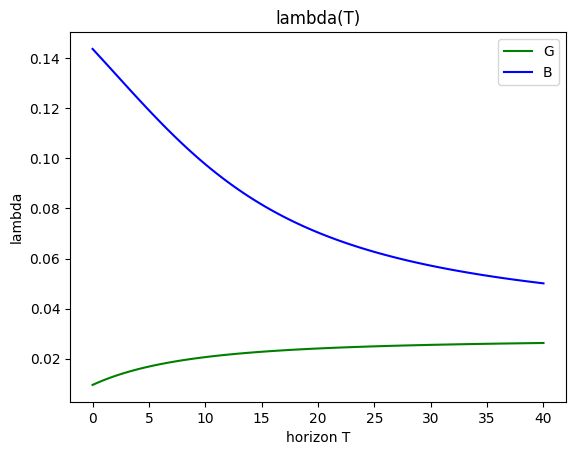

In [7]:
horizons = np.linspace(1e-5, 40, num=100)
X_G = []
X_B = []

for T in horizons:
    X_G.append(1-expm(A*T)[0, -1])
    X_B.append(1-expm(A*T)[1, -1])

lambda_G = -np.log(np.array(X_G))/horizons
lambda_B = -np.log(np.array(X_B))/horizons

plt.plot(horizons,lambda_G, color ='green', label='G')
plt.plot(horizons,lambda_B, color ='blue', label ='B')
plt.title('lambda(T)')
plt.xlabel('horizon T')
plt.ylabel('lambda')
plt.legend()
plt.show()

## Structural Model

\begin{align*}
C(A,D_F,r,T,\sigma) &= E = SN(d_1) - D_Fe^{-rT}N(d_2) \\
\end{align*}
where
\begin{align*}
d_1 &= \frac{1}{\sigma \sqrt{T}}\biggr[ \log \biggl( \frac{A}{D_F} \biggr) + \biggl( r + \frac{\sigma^2}{2} \biggr) T \biggr]\\
d_2 &= d_1 - \sigma\sqrt{T}
\end{align*}

Let's consider a standard Merton model applied to a firm with an initial equity value of $E(t = 0) = \$10$ and a face value of 5-year debt of $D_F = \$10$. The risk-free interest rate, compounded continuously, is denoted as $r = 2\%$. Additionally, we assume that the estimated volatility of the firm's assets is $30\%$.

In [8]:
# Parameter
E0 = 10
Df = 10
r = 0.02
T = 5
sigma = 0.3

In [9]:
def BS(A):
    d1 = (np.log(A/Df) +(r + 1/2 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = (np.log(A/Df) +(r - 1/2 * sigma**2)*T) / (sigma * np.sqrt(T))
    return A * norm.cdf(d1) - Df * (np.exp(-r*T)) * norm.cdf(d2) - E0

solve = fsolve(BS, E0)
asset_initial = solve[0]
debt_initial = asset_initial - E0

d2 = (np.log(asset_initial/Df) +(r - 1/2 * sigma**2)*T) / (sigma * np.sqrt(T))
survival_rate = norm.cdf(d2)


print(f'The time-0 fair price of the firm’s assets is {asset_initial}')
print(f'The time-0 fair price of the firm’s debt is {debt_initial}')
print(f'The 5-year survival (risk-neutral )probability of the firm is {survival_rate}')

The time-0 fair price of the firm’s assets is 18.42882658967022
The time-0 fair price of the firm’s debt is 8.42882658967022
The 5-year survival (risk-neutral )probability of the firm is 0.7657676850600381


Now let's consider an extended Merton model with a constant continuous-time barrier $H_t = H = D_F$. In this model, we assume that the assets have drift $\mu = r$, and all other parameters remain the same as before. Let $\tau := \inf \{t>0 \mid A(t) < H\}$ be the default time of the firm. It can be shown that (using reflection principal):

\begin{align*}
&\Pr(\tau < t) = N(\frac{h-at}{\sigma \sqrt{t}}) + e^{\frac{2ah}{\sigma^2}}N(\frac{h+at}{\sigma \sqrt{t}})\\
& \textit{where } a = r - \frac{\sigma^2}{2} \textit{ and } h = \log(\frac{H}{A(0)})
\end{align*}

In the extended Merton model, any realization that reaches the boundary $H$ and surpasses $D_F$ is considered a default, while in the standard Merton model, it is not categorized as a default. These default realizations have a collective probability greater than zero. However, other realizations are consistently categorized in both models. Consequently, the 5-year survival rate in the extended Merton model is lower compared to the survival rate in the standard Merton model.

In [10]:
a = r - 0.5 * sigma**2
h = np.log(Df / asset_initial)

default_rate = norm.cdf((h - a*T)/(sigma*np.sqrt(T))) +\
                np.exp(2*h*a / sigma**2) * norm.cdf((h + a*T)/(sigma*np.sqrt(T)))
survival_rate = 1 - default_rate

print(f'The 5-year survival probability of the firm is {survival_rate}')

The 5-year survival probability of the firm is 0.5745171658288526


Contrary to real markets, the credit spread term structure $\lambda(T)$ generated by this model exhibits collapsing spreads for short maturities.

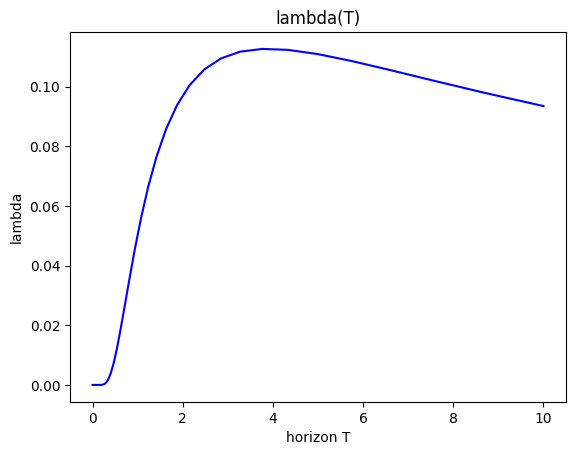

In [11]:
horizons = np.geomspace(1e-5, 10, num=100)
survival_rate = []
a = r - 0.5 * sigma**2
h = np.log(Df / asset_initial)

for T in horizons:
    X_T = 1 - (norm.cdf((h-a*T)/(sigma * np.sqrt(T))) +\
                   np.exp(2*h*a / (sigma**2)) * norm.cdf((h+a*T)/(sigma*np.sqrt(T))))
    survival_rate.append(X_T)

lambda_A = (-np.log(survival_rate)/horizons)

plt.plot(horizons,lambda_A, color ='blue')
plt.title('lambda(T)')
plt.xlabel('horizon T')
plt.ylabel('lambda')
plt.show()